<a href="https://colab.research.google.com/github/jedhouas/Assurance-Vie/blob/master/HOUAS_DELRUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ASSURANCE VIE**


---

### Jed HOUAS & Thomas DELRUE

Janvier 2020


In [0]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from math import *
import scipy.stats as stats
import autograd.numpy as grad
import numpy.linalg as linalg

In [0]:
!pip install actuariat_python
!pip install lmfit
!pip install lifelines

     |████████████████████████████████| 204kB 9.4MB/s 
     |████████████████████████████████| 2.2MB 50.0MB/s 
     |████████████████████████████████| 471kB 49.4MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 256kB 28.8MB/s 
     |████████████████████████████████| 2.1MB 54.0MB/s 
     |████████████████████████████████| 1.1MB 54.8MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 307kB 43.7MB/s 
     |████████████████████████████████| 122kB 38.7MB/s 
     |████████████████████████████████| 235kB 57.7MB/s 
     |████████████████████████████████| 2.7MB 57.2MB/s 
     |████████████████████████████████| 215kB 47.4MB/s 
     |████████████████████████████████| 194kB 53.7MB/s 
     |████████████████████████████████| 215kB 47.4MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 

     |████████████████████████████████| 266kB 8.2MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 235kB 15.8MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.0-cp36-none-any.whl size=87915 sha256=2efc618fd4368e9c4e3b0b17caf7db94a95837eb92f130f929c56a61a97f6d88
  Stored in directory: /root/.cache/pip/wheels/1f/93/e9/8d3f759e466f5bbfed3ba1d7dc5b3d4389c469a1ec9a2acaee
  Created wheel for asteval: filename=asteval-0.9.18-cp36-none-any.whl size=17382 sha256=889ed16b697b8c3b20e8f3593245a353f0708396ccf4f9cc41806eb18405df34
  Stored in directory: /root/.cache/pip/wheels/1c/53/1b/28d929700c9633b1786a4982e6db564ec8326a8930234dcc19
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96458 sha256=203d9f7488fc4694019f06f58be273c6cfeebde088ed4869c3a9ae48d51cbe32
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
Successfully built lmfit asteval uncertainties

In [0]:
from actuariat_python.plots import plot_population_pyramid
from lmfit import Model, Parameters
from lifelines import KaplanMeierFitter
from lifelines import SplineFitter
from lifelines.fitters import ParametricUnivariateFitter
from lifelines.utils import find_best_parametric_model

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
# Mount drive content
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **1) Construction d'une base de données**

In [0]:
# Importer les données dans des DataFrames
df_contrats = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Assurance Vie/Base_Contrats.csv', sep=";")
df_mouvements = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Assurance Vie/Base_Mouvements.csv', sep=";")
df_deaths = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Assurance Vie/Deaths.csv', sep=";")
df_exposures = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Assurance Vie/Exposures.csv', sep=";")
df_death_rates = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Assurance Vie/Mx_1x1.csv', sep=";")
df_THTF0002 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Assurance Vie/TH-TF-00-02.csv', sep=";")

In [0]:
df_contrats.head(1)

,Cnt,Pays,ChargementsGestion,ChargementsSous,CommSous,FreqChgts,TypFisc,Reseau,TxGaranti,Fonds,CSP,Sexe,Civilite,DatNaiss,DatEffet,DatDC,CodSitu,PM
0,66063878.0,FRA,0.99,4.0,0.0,4,STD,Salarie,0.0,EUR,NR,M,M,18/10/2011,12/04/2012,NaN,En Cours,131.16


In [0]:
df_mouvements.head(1)

,Cnt,Pays,TypFisc,Reseau,TxGaranti,Fonds,CSP,Sexe,Civilite,DatNaiss,DatEffetCnt,DatEffet,Typo,Montant
0,71942509.0,FRA,STD,Salarie,0.5,EUR,NR,M,M,16/12/1953,18/03/2005,29/10/2006,DC,282.467139


In [0]:
print("taille base contrats:", len(df_contrats))
print("taille base mouvements:", len(df_mouvements))

taille base contrats: 693198
taille base mouvements: 1517869


Pour la lisibilité, on supprime les colonnes qui ne seront pas utilisées.

In [0]:
# Colonnes inutiles

# Pays
df_contrats = df_contrats.drop(columns="Pays")
df_mouvements = df_mouvements.drop(columns="Pays")
# Type Fiscalité
df_contrats = df_contrats.drop(columns="TypFisc")
df_mouvements = df_mouvements.drop(columns="TypFisc")
# Reseau
df_contrats = df_contrats.drop(columns="Reseau")
df_mouvements = df_mouvements.drop(columns="Reseau")
# CSP
df_contrats = df_contrats.drop(columns="CSP")
df_mouvements = df_mouvements.drop(columns="CSP")
# # Civilité
df_contrats = df_contrats.drop(columns="Civilite")
df_mouvements = df_mouvements.drop(columns="Civilite")

In [0]:
df_contrats.CodSitu.unique()

array(['En Cours', 'Resilie', 'Sinistre'], dtype=object)

Il y a 3 situations possibles pour un contrat: 


*   en cours
*   résilié
*   sinistré (cas de décès)

In [0]:
df_mouvements.Typo.unique()

array(['DC', 'FraisSous', 'Sous', 'RT'], dtype=object)

De même, il y a 4 types de mouvements possibles: 



*   versement en cas de décès
*   rachat total
*   souscription
*   frais de souscription



Avant toute chose, on convertit les dates des bases au format iso pour pouvoir effectuer des calcul avec pandas.

In [0]:
# Convertit les dates de la bdd (jj/mm/aaaa) au format iso (aaaa-mm-dd)

df_contrats['DatNaiss'] = pd.to_datetime(df_contrats.DatNaiss)
df_contrats['DatEffet'] = pd.to_datetime(df_contrats.DatEffet)
df_contrats['DatDC'] = pd.to_datetime(df_contrats.DatDC)
df_mouvements['DatNaiss'] = pd.to_datetime(df_mouvements.DatNaiss)
df_mouvements['DatEffetCnt'] = pd.to_datetime(df_mouvements.DatEffetCnt)
df_mouvements['DatEffet'] = pd.to_datetime(df_mouvements.DatEffet)

On constitue une base qui ne contient que les contrats en cours.

In [0]:
# Que les contrats en cours

df_contrats = df_contrats.dropna(axis=0, how='any', thresh=None, subset=['Sexe'], inplace=False)
df_contrats_encours = df_contrats[df_contrats['CodSitu']=='En Cours']
Cnt_encours = df_contrats_encours['Cnt'].values
no_contrats_encours = len(Cnt_encours)

# **2) Module de valorisation**

In [0]:
# On calcule l'âge de chaque contrat en cours (en années)

today = dt(2013, 12, 31)
df_contrats_encours['AgeContrat'] = df_contrats_encours.apply(lambda line: round((today - line['DatEffet']).days/365.25, 2), axis=1)

In [0]:
print("nombre de contrats en cours:", no_contrats_encours)
print("age moyen des contrats en cours:", round(df_contrats_encours.AgeContrat.mean(),2), "ans")

nombre de contrats en cours: 506195
age moyen des contrats en cours: 8.45 ans


In [0]:
df_contrats_encours.groupby(['Fonds'])['PM'].sum()

Fonds
EUR    1.223249e+10
UC     1.179683e+09
Name: PM, dtype: float64

On trouve:


*   à peu près 500,000 contrats en cours
*   d'âge moyen 8.45 ans
*   une PM totale fonds EUR d'à peu près 12 milliards €
*   une PM totale UC proche de 2 milliards €





**VALORISATION NON TRAITEE**

# **3) Table de mortalité d'expérience**

### **3.1) Statistiques descriptives**

In [0]:
# On supprime les colonnes inutiles pour la suite

df_contrats = df_contrats.drop(columns=['ChargementsGestion', 'ChargementsSous', 'CommSous', 'FreqChgts', 'TxGaranti', 'Fonds', 'PM'])

**Pyramide des âges au 31 décembre 2013**

In [0]:
# On ajoute l'information âge de l'assuré

df_contrats_encours['AgeAssure'] = df_contrats_encours.apply(lambda line: round((today - line['DatNaiss']).days/365.25, 2), axis=1)
df_contrats_encours['AgeAssureEntier'] = df_contrats_encours.apply(lambda line: int(line['AgeAssure']), axis=1)

In [0]:
# On sépare les contrats selon le sexe de l'assuré

df_contrats_encours_H = df_contrats_encours.loc[df_contrats_encours['Sexe']=='M']
df_contrats_encours_F = df_contrats_encours.loc[df_contrats_encours['Sexe']=='F']

In [0]:
df_contrats_encours_F.groupby('AgeAssureEntier').size()

AgeAssureEntier
0     2752
1     1674
2     1254
3     1305
4     1219
      ... 
91       3
92       2
94       1
95       2
96       1
Length: 96, dtype: int64

In [0]:
# Complète la série des âges du PF H
# âges non représentés dans le PF H: 94 et 96 ans

ages_H = list(df_contrats_encours_H.groupby('AgeAssureEntier').size().values)
ages_H.insert(94, 0)
ages_H.insert(96, 0)

In [0]:
df_contrats_encours_F.groupby('AgeAssureEntier').size()

AgeAssureEntier
0     2752
1     1674
2     1254
3     1305
4     1219
      ... 
91       3
92       2
94       1
95       2
96       1
Length: 96, dtype: int64

In [0]:
# Complète la série des âges du PF F
# âge non représenté dans le PF F: 93 ans

ages_F = list(df_contrats_encours_F.groupby('AgeAssureEntier').size().values)
ages_F.insert(93, 0)

In [0]:
df_pyramide = pd.DataFrame()
df_pyramide['Hommes'] = ages_H
df_pyramide['Femmes'] = ages_F

On construit alors la pyramide des âges du portefeuille au 31 décembre 2013:

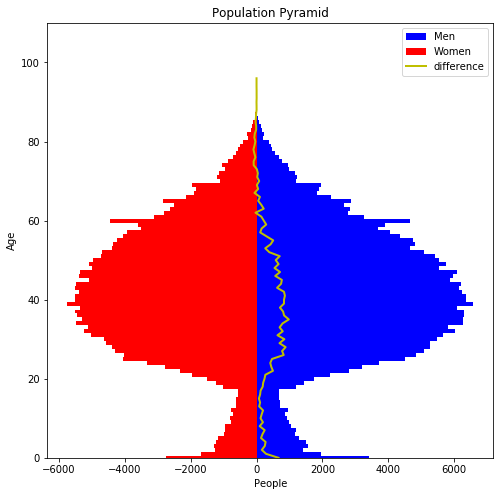

In [0]:
plot_population_pyramid(df_pyramide['Hommes'], df_pyramide['Femmes'], figsize=(8,8))

On constate qu'à presque tous les âges, les hommes sont plus nombreux dans le portefeuille des contrats en cours. Les exceptions concernent les âges après 70 ans.

**Effectifs au 01 janvier**

In [0]:
print("1ere souscription enregistree le", min(df_contrats.DatEffet))

1ere souscription enregistree le 2000-01-01 00:00:00


Le premier contrat en cours remonte au 01 janvier 2000. On s'intéresse aux effectifs du portefeuille pour chaque année de 2000 à 2013 comprises. Les dates d'observation sont prises au 01 janvier.

In [0]:
# On crée un dataframe df_resiliations contenant les Cnt et dates de résiliation correspondantes

df_resiliations = df_mouvements.loc[df_mouvements['Typo']=='RT']
df_resiliations = df_resiliations[['Cnt', 'DatEffet']]
dates = df_resiliations['DatEffet']
df_resiliations = df_resiliations.drop(columns='DatEffet')
df_resiliations['DatRes'] = dates

In [0]:
# On joint les dataframes df_contrats et df_resiliations
# afin d'ajouter une colonne DatRes à df_contrats

df_resiliations.set_index(['Cnt'])
df_contrats.set_index(['Cnt'])
merged = pd.merge(df_contrats, df_resiliations, how='outer', left_on='Cnt', right_on='Cnt')
df_contrats = merged

In [0]:
# On ajoute une colonne fin d'observation

# si contrat en cours, fin d'observation = 31/12/2013
df_contrats.loc[df_contrats['CodSitu']=='En Cours', 'FinObs'] = pd.to_datetime('2013-12-31')
# si sinistre, fin d'observation = date de DC
df_contrats.loc[df_contrats['CodSitu']=='Sinistre', 'FinObs'] = pd.to_datetime(df_contrats.loc[df_contrats['CodSitu']=='Sinistre', 'DatDC'].values)
# si resilie, fin d'observation = date de résiliation
df_contrats.loc[df_contrats['CodSitu']=='Resilie', 'FinObs'] = pd.to_datetime(df_contrats.loc[df_contrats['CodSitu']=='Resilie', 'DatRes'].values)

In [0]:
df_contrats.head(5)

,Cnt,Sexe,DatNaiss,DatEffet,DatDC,CodSitu,DatRes,FinObs
0,66063878.0,M,2011-10-18,2012-12-04,NaT,En Cours,NaT,2013-12-31
1,27158756.0,M,1950-10-31,2006-07-11,NaT,En Cours,NaT,2013-12-31
2,49320745.0,M,1957-06-26,2003-12-30,NaT,En Cours,NaT,2013-12-31
3,26865915.0,M,1993-04-19,2001-10-02,NaT,En Cours,NaT,2013-12-31
4,70595714.0,M,1977-09-06,2004-12-06,NaT,Resilie,2012-09-15,2012-09-15


In [0]:
# Pour qu'un contrat appartienne au PF au 01 janvier de l'année aaaa, il faut:
# 1) que début observation <= 01/01/aaaa
# 2) que fin observation > 01/01/aaaa

contrats_janv_2000 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2000-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2000-01-01') )]
contrats_janv_2001 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2001-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2001-01-01') )]
contrats_janv_2002 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2002-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2002-01-01') )]
contrats_janv_2003 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2003-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2003-01-01') )]
contrats_janv_2004 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2004-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2004-01-01') )]
contrats_janv_2005 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2005-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2005-01-01') )]
contrats_janv_2006 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2006-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2006-01-01') )]
contrats_janv_2007 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2007-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2007-01-01') )]
contrats_janv_2008 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2008-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2008-01-01') )]
contrats_janv_2009 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2009-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2009-01-01') )]
contrats_janv_2010 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2010-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2010-01-01') )]
contrats_janv_2011 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2011-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2011-01-01') )]
contrats_janv_2012 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2012-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2012-01-01') )]
contrats_janv_2013 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2013-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2013-01-01') )]

In [0]:
no_janv_2000 = len(contrats_janv_2000)
no_janv_2001 = len(contrats_janv_2001)
no_janv_2002 = len(contrats_janv_2002)
no_janv_2003 = len(contrats_janv_2003)
no_janv_2004 = len(contrats_janv_2004)
no_janv_2005 = len(contrats_janv_2005)
no_janv_2006 = len(contrats_janv_2006)
no_janv_2007 = len(contrats_janv_2007)
no_janv_2008 = len(contrats_janv_2008)
no_janv_2009 = len(contrats_janv_2009)
no_janv_2010 = len(contrats_janv_2010)
no_janv_2011 = len(contrats_janv_2011)
no_janv_2012 = len(contrats_janv_2012)
no_janv_2013 = len(contrats_janv_2013)

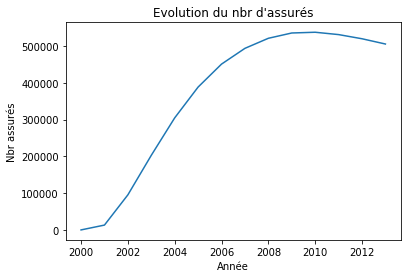

In [0]:
X = [i for i in range(2000, 2014)]
Y = [no_janv_2000, no_janv_2001, no_janv_2002, no_janv_2003, no_janv_2004, no_janv_2005, no_janv_2006, no_janv_2007, no_janv_2008, no_janv_2009,
     no_janv_2010, no_janv_2011, no_janv_2012, no_janv_2013]
plt.plot(X, Y)
plt.xlabel('Année')
plt.ylabel('Nbr assurés')
plt.title("Evolution du nbr d'assurés")
plt.show()

**Sex ratio du PF au 31 décembre 2013**

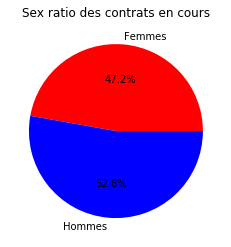

In [0]:
sexes_labels = {'M': "Hommes",
                   'F': "Femmes"}
sexes, sexes_counter = np.unique(df_contrats_encours.Sexe, return_counts=True)
labels_names = np.array([sexes_labels[label] for label in sexes])
colors = ['red', 'blue']
plt.pie(sexes_counter, colors=colors, labels=labels_names, autopct='%1.1f%%')
plt.title('Sex ratio des contrats en cours')
plt.show()

Le portefeuille actuel contient légèrement plus d'hommes que de femmes.

**Ages de décès**

In [0]:
# Ajout d'une colonne âge de DC dans df_contrats

df_contrats.loc[df_contrats['CodSitu']=='Sinistre', 'AgeDC'] = (pd.to_datetime(df_contrats.loc[df_contrats['CodSitu']=='Sinistre', 'DatDC'].values) - 
                                                                       pd.to_datetime(df_contrats.loc[df_contrats['CodSitu']=='Sinistre', 'DatNaiss'].values)).days/365.25

In [0]:
# Ajout d'une colonne année de DC dans df_contrats

df_contrats.loc[df_contrats['CodSitu']=='Sinistre', 'AnneeDC'] = pd.to_datetime(df_contrats.loc[df_contrats['CodSitu']=='Sinistre', 'DatDC'].values).year

In [0]:
df_contrats_DC = df_contrats.dropna(subset=['DatDC'])
no_contrats_DC = len(df_contrats_DC)
no_contrats = len(df_contrats)

In [0]:
print("nombre total de décès observés:", no_contrats_DC)

nombre total de décès observés: 20385


In [0]:
df_contrats_DC_H = df_contrats_DC.loc[df_contrats_DC['Sexe']=='M']
df_contrats_DC_F = df_contrats_DC.loc[df_contrats_DC['Sexe']=='F']

In [0]:
print('age DC max hommes:', int(df_contrats_DC_H.AgeDC.max()))
print('age DC max femmes:', int(df_contrats_DC_F.AgeDC.max()))

age DC max hommes: 94
age DC max femmes: 93


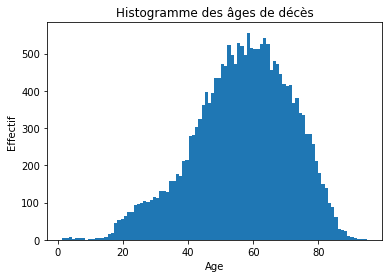

In [0]:
plt.hist(df_contrats_DC.AgeDC, bins=94)
plt.xlabel('Age')
plt.ylabel('Effectif')
plt.title('Histogramme des âges de décès')
plt.show()

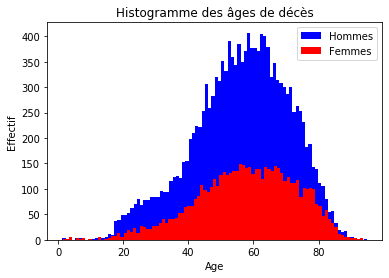

In [0]:
# Meme chose en distinguant les sexes

plt.hist(df_contrats_DC_H.AgeDC, bins=94, color = "b", label='Hommes')
plt.hist(df_contrats_DC_F.AgeDC, bins=94, color = "r", label='Femmes')
plt.xlabel('Age')
plt.ylabel('Effectif')
plt.legend()
plt.title('Histogramme des âges de décès')
plt.show()

Les âges de décès ont des allures de lois normales (la distribution est un peu plus large aux alentours de la vingtaine chez les hommes cependant).
On observe qu'il y a beaucoup plus de décès d'hommes que de femmes.

**Sex ratio des décès**

On le retrouve en calculant le sex ratio des décès:

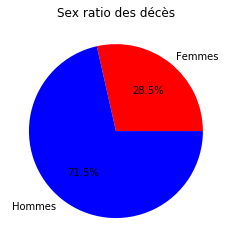

In [0]:
sexes_DC, sexes_DC_counter = np.unique(df_contrats_DC.Sexe, return_counts=True)
labels_names = np.array([sexes_labels[label] for label in sexes_DC])
colors = ['red', 'blue']
plt.pie(sexes_DC_counter, colors=colors, labels=labels_names, autopct='%1.1f%%')
plt.title('Sex ratio des décès')
plt.show()

**Age moyen au décès**

In [0]:
print("âge moyen au décès:", round(df_contrats_DC.AgeDC.mean(),2), "ans")
print("âge moyen au décès H:", round(df_contrats_DC_H.AgeDC.mean(),2), "ans")
print("âge moyen au décès F:", round(df_contrats_DC_F.AgeDC.mean(),2), "ans")

âge moyen au décès: 56.69 ans
âge moyen au décès H: 56.21 ans
âge moyen au décès F: 57.9 ans


**Nombre de décès par an**

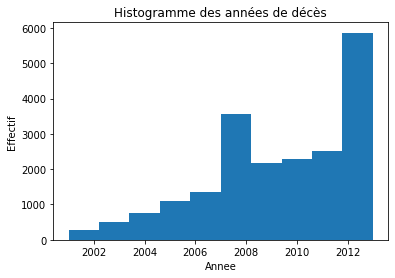

In [0]:
plt.hist(df_contrats_DC.AnneeDC)
plt.xlabel('Annee')
plt.ylabel('Effectif')
plt.title('Histogramme des années de décès')
plt.show()

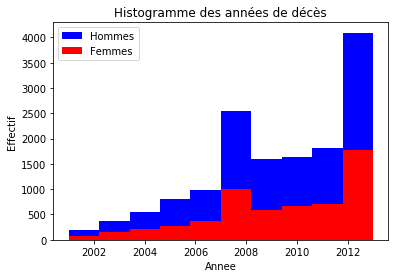

In [0]:
plt.hist(df_contrats_DC_H.AnneeDC, color = "b", label='Hommes')
plt.hist(df_contrats_DC_F.AnneeDC, color = "r", label='Femmes')
plt.xlabel('Annee')
plt.ylabel('Effectif')
plt.legend()
plt.title('Histogramme des années de décès')
plt.show()

### **3.2) Calcul des taux bruts**

**Critère de Cochran**

Déterminons les fenêtres d'âges et d'années sur lesquelles calculer les taux bruts de décès.

Il s'agit de trouver les âges $x \in [0;96] $ et les années $t \in [2000;2013]$ avec suffisamment de donnés.

Posons:

*   $N_{x,t}$ = l'effectif d'âge $x$ en vie au 01 janvier de l'année $t$
*   $d_{x,t}$ = le nombre de décès à l'âge $x$ pendant l'année $t$
*   $\hat q_{x,t}$ = $\frac{d_{x,t}}{N_{x,t}}$ l'estimateur empirique de mortalité


Le critère de Cochran assure que les âges $x$ et les années $t$ convenables vérifient:



*   $ (1) \quad N_{x,t} \times q_{x,t} \geq 5$
*   $ (2) \quad N_{x,t} \times (1-q_{x,t}) \geq 5$



On détaille ci-dessous comment on a calculé une "table de Cochran" pour l'année 2000. Toutes ces étapes sont ensuite reprises dans une fonction pour les autres années.

In [0]:
# Ajout d'une colonne delta_i qui vaut 1 si l'assuré meurt pendant l'année t, 0 sinon

contrats_janv_2000['delta_t'] = contrats_janv_2000['DatDC'].apply(lambda x: 1 if x.year==2000 else 0)

In [0]:
# Ajout d'une colonne anniv

contrats_janv_2000['DatAnniv'] = contrats_janv_2000['DatNaiss'].apply(lambda x: pd.to_datetime('2000' + ' - ' + str(x.month) + ' - ' + str(x.day)))

In [0]:
# Rapporte la fin d'observation à l'année t

contrats_janv_2000['FinObs_t'] = contrats_janv_2000['FinObs'].apply(lambda x: min(x, pd.to_datetime('2000-12-31')))

In [0]:
# Ajout des âges de l'assuré pour l'année t

contrats_janv_2000['Age_x'] = (pd.to_datetime('2000-01-01') - pd.to_datetime(contrats_janv_2000['DatNaiss'].values)).days/365.25
contrats_janv_2000['Age_x+1'] = (pd.to_datetime('2000-12-31') - pd.to_datetime(contrats_janv_2000['DatNaiss'].values)).days/365.25

In [0]:
# Ajout des durées d'exposition à l'âge x pour l'année t (tau_x)

# si l'assuré meurt avant son anniversaire, tau_x = date DC (= date FinObs) - 01 janv
contrats_janv_2000.loc[contrats_janv_2000['FinObs'] <= contrats_janv_2000['DatAnniv'], 'tau_x'] = contrats_janv_2000['FinObs'] - pd.to_datetime('2000-01-01')
# Sinon tau_x = date anniv - 01 janv
contrats_janv_2000.loc[contrats_janv_2000['FinObs'] > contrats_janv_2000['DatAnniv'], 'tau_x'] = contrats_janv_2000['DatAnniv'] - pd.to_datetime('2000-01-01')

In [0]:
# Ajout des durées d'exposition à l'âge x+1 pour l'année t (tau_x+1)

# si l'assuré meurt avant son anniversaire, tau_x+1 = 0
contrats_janv_2000.loc[contrats_janv_2000['FinObs'] <= contrats_janv_2000['DatAnniv'], 'tau_x+1'] = pd.to_timedelta(0)
# s'il meurt entre son anniversaire et le 31 déc, tau_x+1 = date DC (= date FinObs) - date anniv
contrats_janv_2000.loc[(contrats_janv_2000['FinObs'] > contrats_janv_2000['DatAnniv']) & (contrats_janv_2000['FinObs'] > contrats_janv_2000['DatAnniv']), 'tau_x+1'] = contrats_janv_2000['FinObs'] - contrats_janv_2000['DatAnniv']
# sinon tau_x+1 = 31 déc - date anniv
contrats_janv_2000.loc[contrats_janv_2000['FinObs'] > pd.to_datetime('2000-12-31'), 'tau_x+1'] = pd.to_datetime('2000-12-31') - contrats_janv_2000['DatAnniv']

In [0]:
contrats_janv_2000['Age_x'] = contrats_janv_2000['Age_x'].apply(lambda x: int(x))
contrats_janv_2000['Age_x+1'] = contrats_janv_2000['Age_x+1'].apply(lambda x: int(x))
contrats_janv_2000['tau_x'] = contrats_janv_2000['tau_x'].apply(lambda x: x.days/365.25)
contrats_janv_2000['tau_x+1'] = contrats_janv_2000['tau_x+1'].apply(lambda x: x.days/365.25)

In [0]:
contrats_janv_2000_x = contrats_janv_2000[['delta_t', 'Age_x', 'tau_x']]
contrats_janv_2000_y = contrats_janv_2000[['delta_t', 'Age_x+1', 'tau_x+1']]
contrats_janv_2000_y = contrats_janv_2000_y.rename(columns={"Age_x+1": "Age_x", "tau_x+1": "tau_x"})
result_2000 = pd.concat([contrats_janv_2000_x, contrats_janv_2000_y])

In [0]:
result_2000['N_xt'] = result_2000['delta_t'].apply(lambda x: 1)
result_2000 = result_2000.rename(columns={"delta_t": "D_xt", "tau_x": "E_xt"})
# on regroupe par âge
result_2000 = result_2000.groupby('Age_x').sum()
# on a compté les DC de l'année 2 fois
result_2000['D_xt'] = result_2000['D_xt'].apply(lambda x: x//2)
result_2000['q_xt'] = result_2000['D_xt']/result_2000['E_xt']
# 1e critère de Cochran: N_xt * q_xt >= 5
result_2000['Cochran_1'] = result_2000['N_xt']*result_2000['q_xt']
# 2e critère de Cochran: N_xt * (1-q_xt) >= 5
result_2000['Cochran_2'] =  result_2000['N_xt']*(1-result_2000['q_xt'])

In [0]:
def get_cochran_table(annee):
  contrats_janv = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime(str(annee) +' -01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime(str(annee) +' -01-01') )]
  contrats_janv['delta_t'] = contrats_janv['DatDC'].apply(lambda x: 1 if x.year==annee else 0)
  contrats_janv['DatAnniv'] = contrats_janv['DatNaiss'].apply(lambda x: pd.to_datetime(str(annee) + '-' + str(x.month) + '-' + str(x.day)))
  contrats_janv['FinObs_t'] = contrats_janv['FinObs'].apply(lambda x: min(x, pd.to_datetime(str(annee) + '-12-31')))
  contrats_janv['Age_x'] = (pd.to_datetime(str(annee) + '-01-01') - pd.to_datetime(contrats_janv['DatNaiss'].values)).days/365.25
  contrats_janv['Age_x+1'] = (pd.to_datetime(str(annee) + '-12-31') - pd.to_datetime(contrats_janv['DatNaiss'].values)).days/365.25
  contrats_janv.loc[contrats_janv['FinObs'] <= contrats_janv['DatAnniv'], 'tau_x'] = contrats_janv['FinObs'] - pd.to_datetime(str(annee) + '-01-01')
  contrats_janv.loc[contrats_janv['FinObs'] > contrats_janv['DatAnniv'], 'tau_x'] = contrats_janv['DatAnniv'] - pd.to_datetime(str(annee) + '-01-01')
  contrats_janv.loc[contrats_janv['FinObs'] <= contrats_janv['DatAnniv'], 'tau_x+1'] = pd.to_timedelta(0)
  contrats_janv.loc[(contrats_janv['FinObs'] > contrats_janv['DatAnniv']) & (contrats_janv['FinObs'] > contrats_janv['DatAnniv']), 'tau_x+1'] = contrats_janv['FinObs'] - contrats_janv['DatAnniv']
  contrats_janv.loc[contrats_janv['FinObs'] > pd.to_datetime(str(annee) + '-12-31'), 'tau_x+1'] = pd.to_datetime(str(annee) + '-12-31') - contrats_janv['DatAnniv']
  contrats_janv['Age_x'] = contrats_janv['Age_x'].apply(lambda x: int(x))
  contrats_janv['Age_x+1'] = contrats_janv['Age_x+1'].apply(lambda x: int(x))
  contrats_janv['tau_x'] = contrats_janv['tau_x'].apply(lambda x: x.days/365.25)
  contrats_janv['tau_x+1'] = contrats_janv['tau_x+1'].apply(lambda x: x.days/365.25)
  contrats_janv_x = contrats_janv[['delta_t', 'Age_x', 'tau_x']]
  contrats_janv_y = contrats_janv[['delta_t', 'Age_x+1', 'tau_x+1']]
  contrats_janv_y = contrats_janv_y.rename(columns={"Age_x+1": "Age_x", "tau_x+1": "tau_x"})
  result = pd.concat([contrats_janv_x, contrats_janv_y])
  result['N_xt'] = result['delta_t'].apply(lambda x: 1)
  result = result.rename(columns={"delta_t": "D_xt", "tau_x": "E_xt"})
  result = result.groupby('Age_x').sum()
  result['D_xt'] = result['D_xt'].apply(lambda x: x//2)
  result['q_xt'] = result['D_xt']/result['E_xt']
  result['Cochran_1'] = result['N_xt']*result['q_xt']
  result['Cochran_2'] =  result['N_xt']*(1-result['q_xt'])

  return result

In [0]:
# attention: met du temps à tourner

result_2001 = get_cochran_table(2001)
result_2002 = get_cochran_table(2002)
result_2003 = get_cochran_table(2003)
result_2004 = get_cochran_table(2004)
result_2005 = get_cochran_table(2005)
result_2006 = get_cochran_table(2006)
result_2007 = get_cochran_table(2007)
result_2008 = get_cochran_table(2008)
result_2009 = get_cochran_table(2009)
result_2010 = get_cochran_table(2010)
result_2011 = get_cochran_table(2011)
result_2012 = get_cochran_table(2012)
result_2013 = get_cochran_table(2013)

On va maintenant lire sur ces tables les âges qui respectent le critère de Cochran.

In [0]:
def color(val):
    if val > 5:
      color = 'lightblue'
    else:
      color = ''
    return 'background-color: %s' % color

Les cases colorées vérifient le critère. Par exemple, pour l'année 2010:

In [0]:
result_2010.style.applymap(color, subset=['Cochran_1', 'Cochran_2'])

,D_xt,E_xt,N_xt,q_xt,Cochran_1,Cochran_2
Age_x,,,,,,
0,0,0.785763,3,0,0,3
1,0,1244.65,2542,0,0,2542
2,0,2375.5,4776,0,0,4776
3,1,2172.44,4493,0.000460312,2.06818,4490.93
4,0,2155.24,4342,0,0,4342
5,1,1972.77,4008,0.000506902,2.03166,4005.97
6,1,1867.18,3827,0.000535567,2.04961,3824.95
7,0,1796.28,3645,0,0,3645
8,0,1749.13,3660,0,0,3660


Le dataframe ci-dessous rassemble les intervalles $[x_{min};x_{max}]$ vérifiant le critère de Cochran. Suite à ces observations, nous décidons de calculer les taux bruts pour les années $t \in [2006;2013]$ et les âges $x \in [20;80]$.

In [0]:
critere_de_cochran = pd.DataFrame()
critere_de_cochran['Annee'] = [i for i in range(2000, 2014)]
critere_de_cochran['x_min'] = [np.nan, np.nan, 36, 31, 28, 17, 17, 17, 16, 17, 18, 18, 19, 18]
critere_de_cochran['x_max'] = [np.nan, np.nan, 67, 76, 77, 79, 80, 82, 83, 85, 88, 87, 89, 88]
critere_de_cochran

,Annee,x_min,x_max
0,2000,NaN,NaN
1,2001,NaN,NaN
2,2002,36.0,67.0
3,2003,31.0,76.0
4,2004,28.0,77.0
5,2005,17.0,79.0
6,2006,17.0,80.0
7,2007,17.0,82.0
8,2008,16.0,83.0
9,2009,17.0,85.0


On peut maintenant calculer les taux bruts avec l'estimateur de Kaplan-Meier vu en cours. On utilisera le package *lifelines*.

In [0]:
# Population d'étude = contenance du PF du 01 janvier 2006 au 31 décembre 2013

contrats_janv_2006 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2006-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2006-01-01') )]
contrats_janv_2007 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2007-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2007-01-01') )]
contrats_janv_2008 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2008-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2008-01-01') )]
contrats_janv_2009 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2009-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2009-01-01') )]
contrats_janv_2010 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2010-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2010-01-01') )]
contrats_janv_2011 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2011-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2011-01-01') )]
contrats_janv_2012 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2012-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2012-01-01') )]
contrats_janv_2013 = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime('2013-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime('2013-01-01') )]
dataframes = [contrats_janv_2006, contrats_janv_2007, contrats_janv_2008, contrats_janv_2009, contrats_janv_2010, contrats_janv_2011, contrats_janv_2012, contrats_janv_2013]
population = pd.concat(dataframes).drop_duplicates().reset_index(drop=True)

In [0]:
print("effectif total: ", len(population))
print("effectif observé: ", len(population.loc[population['CodSitu']=='Sinistre']))
print("effectif censuré/tronqué: ", len(population) - len(population.loc[population['CodSitu']=='Sinistre']))

effectif total:  642856
effectif observé:  17757
effectif censuré/tronqué:  625099


In [0]:
# Ajout d'une colonne Observed

# 1 si le décès est observé, 0 sinon
population.loc[population['CodSitu']=='Sinistre', 'Observed'] = 1
population.loc[population['CodSitu']!='Sinistre', 'Observed'] = 0

In [0]:
# Ajout d'une colonne Duration

population.loc[population['CodSitu']=='Sinistre', 'Duration'] = population['AgeDC']
population.loc[population['CodSitu']=='En Cours', 'Duration'] = (pd.to_datetime('2013-12-31') - pd.to_datetime(population.loc[population['CodSitu']=='En Cours', 'DatNaiss'].values)).days/365.25
population.loc[population['CodSitu']=='Resilie', 'Duration'] = (pd.to_datetime(population.loc[population['CodSitu']=='Resilie', 'DatRes'].values) - pd.to_datetime(population.loc[population['CodSitu']=='Resilie', 'DatNaiss'].values)).days/365.25

In [0]:
population['Observed'] = population['Observed'].apply(lambda x: int(x))
population['Duration'] = population['Duration'].apply(lambda x: int(x))

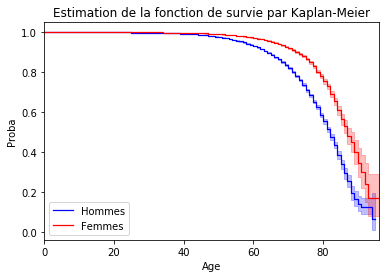

In [0]:
# Fonction de survie: estimateur de Kaplan-Meier

T = population["Duration"]
E = population["Observed"]

kmf_H = KaplanMeierFitter()
kmf_F = KaplanMeierFitter()

H = (population["Sexe"] == "M")

kmf_H.fit(T[H], event_observed=E[H], label="Hommes")
kmf_F.fit(T[~H], event_observed=E[~H], label="Femmes")

kmf_H.plot(color='b', linewidth=1.25)
kmf_F.plot(color='r', linewidth=1.25)

plt.xlabel('Age')
plt.ylabel('Proba')
plt.title('Estimation de la fonction de survie par Kaplan-Meier')
plt.show()

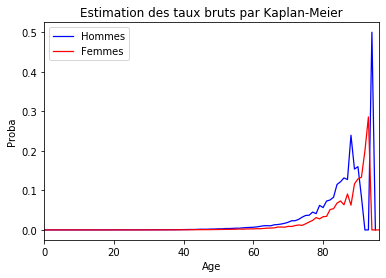

In [0]:
# Taux bruts: estimateur de Kaplan-Meier

survival_km_H = kmf_H.survival_function_
survival_km_F = kmf_F.survival_function_

taux_bruts_H = -survival_km_H.pct_change()
taux_bruts_H.iloc[0]['Hommes'] = 0
taux_bruts_F = -survival_km_F.pct_change()
taux_bruts_F.iloc[0]['Femmes'] = 0

fig = plt.figure()
ax = fig.add_subplot(111)
taux_bruts_H.plot(ax=ax, color='b', linewidth=1.25)
taux_bruts_F.plot(ax=ax, color='r', linewidth=1.25)

plt.xlabel('Age')
plt.ylabel('Proba')
plt.title('Estimation des taux bruts par Kaplan-Meier')
plt.show()

Dans notre population comme dans la population en général, les femmes meurent moins vite que les hommes.

### **3.3) Lissage des taux bruts**

**a) Lissage**

On commence par lisser les taux bruts avec une méthode paramétrique: le modèle de Gompertz-Makeham.

In [0]:
class GompertzFitter(ParametricUnivariateFitter):
    _fitted_parameter_names = ['nu_', 'b_']

    def _cumulative_hazard(self, params, times):
        nu_, b_ = params
        return nu_ * (grad.expm1(times * b_))

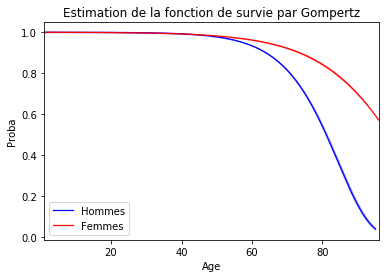

In [0]:
# Lissage paramétrique: méthode de Gompertz-Makeham
# Fonction de survie

gptz_H = GompertzFitter()
gptz_F = GompertzFitter()

H = (population["Sexe"] == "M")

gptz_H.fit(T[H], event_observed=E[H], label="Hommes")
gptz_F.fit(T[~H], event_observed=E[~H], label="Femmes")

gptz_H.plot_survival_function(color='b', linewidth=1.25)
gptz_F.plot_survival_function(color='r', linewidth=1.25)

plt.xlabel('Age')
plt.ylabel('Proba')
plt.title('Estimation de la fonction de survie par Gompertz')
plt.show()

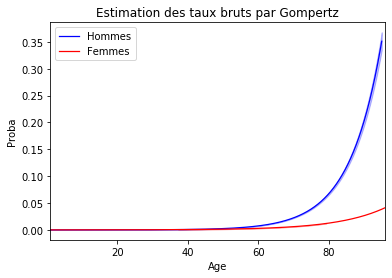

In [0]:
# Lissage paramétrique: méthode de Gompertz-Makeham
# Taux

taux_lisses_wb_H = gptz_H.hazard_
taux_lisses_wb_F = gptz_F.hazard_

gptz_H.plot_hazard(color='b', linewidth=1.25)
gptz_F.plot_hazard(color='r', linewidth=1.25)

plt.xlabel('Age')
plt.ylabel('Proba')
plt.title('Estimation des taux bruts par Gompertz')
plt.show()

Le lissage de Gompertz-Makeham semble accentuer la différence observée entre hommes et femmes. Essayons maintenant une méthode non-paramétrique, par exemple celle des splines polynomiaux.

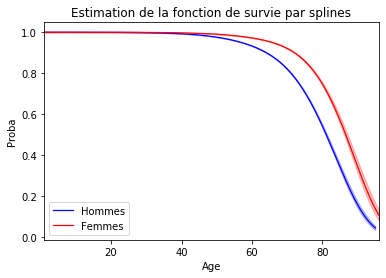

In [0]:
# Lissage non-paramétrique: splines polynomiaux
# Fonction de survie

H = (population["Sexe"] == "M")

knots_H = np.percentile(T[H].loc[E[H].astype(bool)], [0, 50, 75, 100])
knots_F = np.percentile(T[~H].loc[E[~H].astype(bool)], [0, 50, 75, 100])

sf_H = SplineFitter(knots_H)
sf_F = SplineFitter(knots_F)

sf_H.fit(T[H], E[H], label="Hommes")
sf_F.fit(T[~H], E[~H], label="Femmes")

sf_H.plot_survival_function(color='b', linewidth=1.25)
sf_F.plot_survival_function(color='r', linewidth=1.25)

plt.xlabel('Age')
plt.ylabel('Proba')
plt.title('Estimation de la fonction de survie par splines')
plt.show()

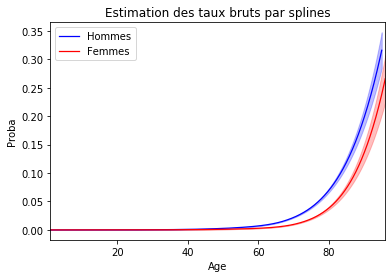

In [0]:
# Lissage non-paramétrique: splines polynomiaux
# Taux

taux_lisses_splines_H = sf_H.hazard_
taux_lisses_splines_F = sf_F.hazard_

sf_H.plot_hazard(color='b', linewidth=1.25)
sf_F.plot_hazard(color='r', linewidth=1.25)

plt.xlabel('Age')
plt.ylabel('Proba')
plt.title('Estimation des taux bruts par splines')
plt.show()

Le lissage par splines fait apparaître un écart moins important entre hommes et femmes, comme avec l'estimateur de Kaplan-Meier. 

**b) Comparaison graphique**

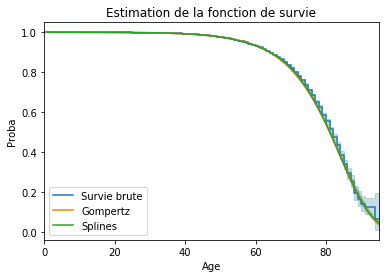

In [0]:
# Fonction de survie hommes

kmf_H.fit(T[H], event_observed=E[H], label="Survie brute")
gptz_H.fit(T[H], event_observed=E[H], label="Gompertz")
sf_H.fit(T[H], E[H], label="Splines")

kmf_H.plot_survival_function()
gptz_H.plot_survival_function()
sf_H.plot_survival_function()

plt.xlabel('Age')
plt.ylabel('Proba')
plt.title('Estimation de la fonction de survie')
plt.show()

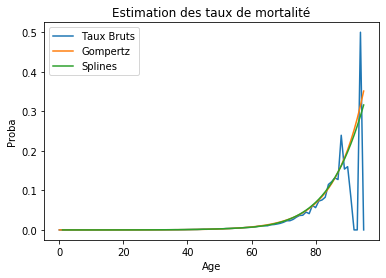

In [0]:
# Taux hommes

times_H = np.linspace(0, 95, 96)
taux_lisses_Gompertz_H = gptz_H.hazard_at_times(times_H).values
taux_lisses_splines_H = sf_H.hazard_at_times(times_H).values

plt.plot(times_H, taux_bruts_H, label='Taux Bruts')
plt.plot(times_H, taux_lisses_Gompertz_H, label='Gompertz')
plt.plot(times_H, taux_lisses_splines_H, label='Splines')
plt.legend()

plt.xlabel('Age')
plt.ylabel('Proba')
plt.title('Estimation des taux de mortalité')
plt.show()

Les deux lissages sont graphiquement très proches l'un de l'autre pour les hommes.

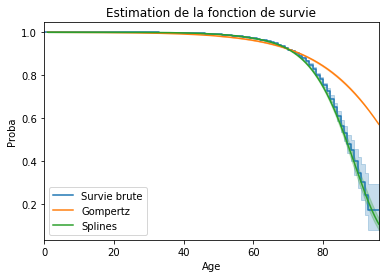

In [0]:
# Fonction de survie femmes

kmf_F.fit(T[~H], event_observed=E[~H], label="Survie brute")
gptz_F.fit(T[~H], event_observed=E[~H], label="Gompertz")
sf_F.fit(T[~H], E[~H], label="Splines")

kmf_F.plot_survival_function()
gptz_F.plot_survival_function()
sf_F.plot_survival_function()

plt.xlabel('Age')
plt.ylabel('Proba')
plt.title('Estimation de la fonction de survie')
plt.show()

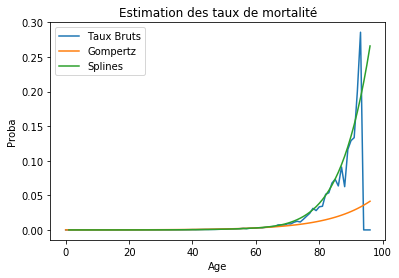

In [0]:
times_F = np.linspace(0, 96, 97)

taux_lisses_Gompertz_F = gptz_F.hazard_at_times(times_F).values
taux_lisses_splines_F = sf_F.hazard_at_times(times_F).values

plt.plot(times_F, taux_bruts_F, label='Taux Bruts')
plt.plot(times_F, taux_lisses_Gompertz_F, label='Gompertz')
plt.plot(times_F, taux_lisses_splines_F, label='Splines')
plt.legend()

plt.xlabel('Age')
plt.ylabel('Proba')
plt.title('Estimation des taux de mortalité')
plt.show()

En revanche, les deux lissages s'écartent aux grands âges pour les femmes. Le lissage par splines a l'air meilleur. On va confirmer cette intuition avec des tests statistiques.

### **c) Tests statistiques**

Par souci de simplicité, on va réaliser les tests sur la population totale et ne pas séparer les sexes.

**Test du Chi-2**

In [0]:
# Calcul des expositions pour chaque âge x de notre population

df_test = pd.DataFrame()
df_test['E_x'] = (result_2006['E_xt'] + result_2007['E_xt'] + result_2008['E_xt'] + result_2009['E_xt'] + result_2010['E_xt']
+ result_2011['E_xt'] + result_2012['E_xt'] + result_2013['E_xt'])/8
df_test = df_test.loc[(df_test.index >= 60) & (df_test.index <= 80)]

In [0]:
times = np.linspace(60, 80, 21)

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)
survival_km = kmf.survival_function_
taux_bruts = -survival_km.pct_change()['KM_estimate'].values[60:81]

gptz = GompertzFitter()
gptz.fit(T, event_observed=E)
taux_lisses_Gompertz = gptz.hazard_at_times(times).values

knots = np.percentile(T.loc[E.astype(bool)], [0, 50, 75, 100])
sf = SplineFitter(knots)
sf.fit(T, E)
taux_lisses_splines = sf.hazard_at_times(times).values

In [0]:
df_test['taux bruts'] = taux_bruts
df_test['taux Gompertz'] = taux_lisses_Gompertz
df_test['taux splines'] = taux_lisses_splines
df_test['Gompertz-bruts'] = df_test['taux Gompertz'] - df_test['taux bruts']
df_test['splines-bruts'] = df_test['taux splines'] - df_test['taux bruts']

In [0]:
# Calcul des statistiques de test

statistique_Gompertz = (df_test['E_x']*(df_test['taux bruts'] - df_test['taux Gompertz'])**2/df_test['taux Gompertz']).sum()
statistique_splines = (df_test['E_x']*(df_test['taux bruts'] - df_test['taux splines'])**2/df_test['taux splines']).sum()

In [0]:
statistique_Gompertz

10.125490583849604

In [0]:
statistique_splines

6.060542838175609

In [0]:
stats.chi2.sf(statistique_Gompertz, 20, loc=0, scale=1)

0.9658389246985615

In [0]:
stats.chi2.sf(statistique_splines, 20, loc=0, scale=1)

0.9988132514459961

On trouve une plus grande p-valeur pour la statistique du lissage par splines, ce qui conforte notre intuition graphique.

**Test des signes**

In [0]:
import statsmodels.stats.descriptivestats as ssd

In [0]:
ssd.sign_test(df_test['Gompertz-bruts'], mu0=0)

(9.5, 2.09808349609375e-05)

In [0]:
ssd.sign_test(df_test['splines-bruts'], mu0=0)

(8.5, 0.00022125244140625)

Ici les p-values sont un peu aberrantes (erreur dans nos calculs?) mais on retrouve encore une plus grande p-valeur dans le cas du lissage par splines.

Pour finir de se convaincre que le meilleur lissage est la méthode des splines polynomiaux, on fait appel à la fonction *find_best_parametric_model()* du package *lifelines*. Cette fonction calcule les critères d'information d'Akaike d'un ensemble de modèles donnés (Gompertz, Weibull, splines...) et sélectionne le modèle de plus faible critère.

**Critère AIC**

In [0]:
best_model, best_aic_ = find_best_parametric_model(T, E)

print(best_model)

<lifelines.SplineFitter:"Spline_estimate", fitted with 642856 total observations, 625099 right-censored observations>


### **3.4) Fermeture de la table**

Les modèles de lissage précédents ne sont pas adaptés aux grands âges (leur forme exponentielle les fera dépasser 1.0 avant des âges tout à fait atteignables). On va utiliser une autre méthode pour calculer les probabilités des grands âges.

On utilise la méthode de Denuit et Goderniaux, qui consiste en une régression log-quadratique des taux de mortalité. On choisit un âge limite de 130 ans.

Précisément, il s'agit de trouver les coefficients $a$, $b$ et $c$ qui minimisent l'écart quadratique entre les fonctions $x \mapsto \ln(\hat q_x)$ et $x \mapsto a + bx + cx^2$, sous les contraintes $q_{130} = 0$ et $q_{130}' = 0$.

In [0]:
taux_lisses_splines_H[0] = taux_lisses_splines_H[1]
taux_lisses_splines_F[0] = taux_lisses_splines_F[1]
table_experience_H = np.log(taux_lisses_splines_H)
table_experience_F = np.log(taux_lisses_splines_F)

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 96
    # variables        = 1
    chi-square         = 34.1972225
    reduced chi-square = 0.35997076
    Akaike info crit   = -97.0915613
    Bayesian info crit = -94.5272131
[[Variables]]
    c: -8.1601e-04 +/- 6.9005e-06 (0.85%) (init = 1)
    b:  0.21216193 +/- 0.00179414 (0.85%) == '-260*c'
    a: -13.7905255 +/- 0.11661920 (0.85%) == '16900*c'


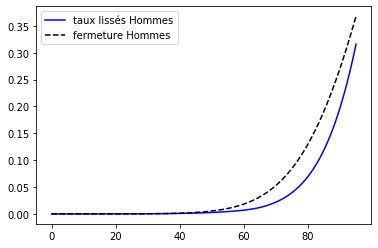

In [0]:
# Détermination des coefficients hommes

def func(x, a, b, c):
    return c*x**2 + b*x + a

x = times_H
y = table_experience_H

pmodel = Model(func)
params = Parameters()
params.add('c', value=1)
params.add('b', expr='-260*c')
params.add('a', expr='16900*c')

result_H = pmodel.fit(y, params, x=x)

print(result_H.fit_report())

xnew = np.linspace(x[0], x[-1], 1000)
ynew = result_H.eval(x=xnew)

plt.plot(x, np.exp(y), 'b-', label='taux lissés Hommes')
plt.plot(xnew, np.exp(ynew), 'k--', label='fermeture Hommes')
plt.legend()
plt.show()

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 97
    # variables        = 1
    chi-square         = 91.5598187
    reduced chi-square = 0.95374811
    Akaike info crit   = -3.59869101
    Bayesian info crit = -1.02398003
[[Variables]]
    c: -8.9520e-04 +/- 1.1231e-05 (1.25%) (init = 1)
    b:  0.23275150 +/- 0.00292013 (1.25%) == '-260*c'
    a: -15.1288472 +/- 0.18980818 (1.25%) == '16900*c'


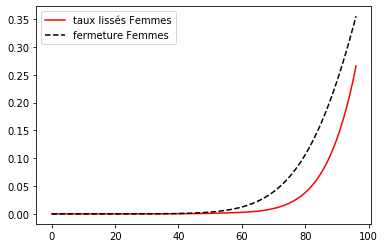

In [0]:
# Détermination des coefficients femmes

x = times_F
y = table_experience_F

pmodel = Model(func)
params = Parameters()
params.add('c', value=1)
params.add('b', expr='-260*c')
params.add('a', expr='16900*c')

result_F = pmodel.fit(y, params, x=x)

print(result_F.fit_report())

xnew = np.linspace(x[0], x[-1], 1000)
ynew = result_F.eval(x=xnew)

plt.plot(x, np.exp(y), 'r-', label='taux lissés Femmes')
plt.plot(xnew, np.exp(ynew), 'k--', label='fermeture Femmes')
plt.legend()
plt.show()

In [0]:
def fermeture_H(x):
  coeffs = result_H.values
  return exp(coeffs['c']*x**2 + coeffs['b']*x + coeffs['a'])

def fermeture_F(x):
  coeffs = result_F.values
  return exp(coeffs['c']*x**2 + coeffs['b']*x + coeffs['a'])

In [0]:
# On conserve toutes les valeurs des taux lissés jusqu'à 95 ans pour les Hommes
# les taux allant de 96 à 130 ans sont extrapolés avec la fonction de fermeture

annees_fermeture_H = np.linspace(96, 130, 35)
valeurs_fermeture_H = [fermeture_H(x) for x in annees_fermeture_H]

table_fermee_H = pd.DataFrame()
table_fermee_H['q_x'] = np.append(np.exp(table_experience_H), valeurs_fermeture_H)

In [0]:
# on conserve toutes les valeurs des taux lissés jusqu'à 96 ans pour les Femmes
# les taux allant de 97 à 130 ans sont extrapolés avec la fonction de fermeture

annees_fermeture_F = np.linspace(97, 130, 34)
valeurs_fermeture_F = [fermeture_F(x) for x in annees_fermeture_F]

table_fermee_F = pd.DataFrame()
table_fermee_F['q_x'] = np.append(np.exp(table_experience_F), valeurs_fermeture_F)

In [0]:
table_fermee_H

,q_x
0,0.000003
1,0.000003
2,0.000002
3,0.000003
4,0.000004
...,...
126,0.987029
127,0.992683
128,0.996741
129,0.999184


In [0]:
table_fermee_F

,q_x
0,0.000002
1,0.000002
2,0.000002
3,0.000002
4,0.000002
...,...
126,0.985779
127,0.991976
128,0.996426
129,0.999105


Enfin, on code une fonction qui reprend les étapes précédentes. La fonction *get_life_table()* prend en entrées l'année (type *int*) et le sexe ('M' ou 'F', type *str*) et renvoie la table fermée correspondante. On y fera appel dans la partie 4).

In [0]:
def get_life_table(annee, sexe):
  # annee = int, sexe = 'M' ou 'F'
  population = df_contrats.loc[( df_contrats['DatEffet']<=pd.to_datetime(str(annee) + '-01-01') )  &  ( df_contrats['FinObs']>pd.to_datetime(str(annee) + '-01-01') )]
  # ajout d'une colonne observed
  # 1 si le décès est observé pendant l'année, 0 sinon
  population['Observed'] = population['DatDC'].apply(lambda x: 1 if x.year==annee else 0)
  population['Observed'] = population['Observed'].apply(lambda x: int(x))
  # ajout d'une colonne duration
  population.loc[population['Observed']==1, 'Duration'] = population['AgeDC']
  # ici la borne sup du temps = 01 janvier de l'année considérée
  # si on meurt/résilie après dans la fenêtre, ou qu'on est encore là au 31-12-2013 alors
  population.loc[(population['CodSitu']=='En Cours')|(pd.to_datetime(population['DatRes'].values).year>annee)|(pd.to_datetime(population['DatDC'].values).year>annee), 'Duration'] = (pd.to_datetime(str(annee) + '-12-31') - pd.to_datetime(population.loc[(population['CodSitu']=='En Cours')|(pd.to_datetime(population['DatRes'].values).year>annee)|(pd.to_datetime(population['DatDC'].values).year>annee), 'DatNaiss'].values)).days/365.25
  population.loc[pd.to_datetime(population['DatRes'].values).year==annee, 'Duration'] = (pd.to_datetime(population.loc[pd.to_datetime(population['DatRes'].values).year==annee, 'DatRes'].values) - pd.to_datetime(population.loc[pd.to_datetime(population['DatRes'].values).year==annee, 'DatNaiss'].values)).days/365.25
  population['Duration'] = population['Duration'].apply(lambda x: int(x))

  T = population["Duration"]
  E = population["Observed"]

  H = (population["Sexe"] == sexe)
  knots = np.percentile(T[H].loc[E[H].astype(bool)], [0, 50, 75, 100])
  sf = SplineFitter(knots)
  sf.fit(T[H], E[H])

  if sexe == 'M':
    times = np.linspace(0, 95, 96)
    annees_fermeture = np.linspace(96, 130, 35)
  else:
    times = np.linspace(0, 96, 97)
    annees_fermeture = np.linspace(97, 130, 34)

  taux_lisses_splines = sf.hazard_at_times(times).values
  taux_lisses_splines[0] = taux_lisses_splines[1]

  table_experience = np.log(np.abs(taux_lisses_splines))

  x = times
  y = table_experience
  pmodel = Model(func)
  params = Parameters()
  params.add('c', value=1)
  params.add('b', expr='-260*c')
  params.add('a', expr='16900*c')
  result = pmodel.fit(y, params, x=x)

  coeffs = result.values

  valeurs_fermeture = [exp(coeffs['c']*x**2 + coeffs['b']*x + coeffs['a']) for x in annees_fermeture]

  table_fermee = pd.DataFrame()
  table_fermee['q_x'] = np.append(np.exp(table_experience), valeurs_fermeture)

  return table_fermee

# **4) Table de mortalité prospective**

## **4.1) Modèle de Lee-Carter**

$$ ln(\mu_{x,t}) = \alpha_x + \beta_x * k_t + \epsilon_{x,t} 
\Longrightarrow 
\\ (\alpha_x, \beta_x, k_t) = argmin \sum_{x,t} (ln(\mu_{x,t}) - \alpha_x - \beta_x * k_t)$$
Sous les constraintes:
$ \sum_{x = x_1}^{x_m} \beta_x = 1$  et  $ \sum_{t = t_1}^{t_n} k_t = 0$ 
 
Nous estimerons ces paramères par moindres carrés ordinaires:


$$ LS(\alpha, \beta, k) = \sum_{x,t} (ln(\mu_{x,t}^*) - \alpha_x - \beta_x * k_t)^2$$

En dérivant par rapport aux variables cherchées $(\alpha_x, \beta_x, k_t)$, on obtient:

$$ \alpha_x = \frac{\sum_{t}ln(\mu_{x,t})}{t_n-t_1-1}$$


Les estimations de $\beta_x$ et $k_t$ sont obtenues en utilisant la décomposition en valeurs singulières de la matrice M = $(ln(\mu_{x_i,t_j}) − \alpha_{x_i} )_{i,j}$. En particulier, étant donnée la décomposition $M = USV^T$, les paramètres ont été estimés comme suit:
$$\beta_x = \frac{u_1}{ \sum_{j = 1}^{x_m-x_1+1} u_{1j} } $$
$$ k_t = (\sum_{j = 1}^{x_m-x_1+1} u_{1j})s_1v_1^T$$
avec:\
$u_1$ le vecteur propre correspondant à la plus grande valeur propre de la matrice $MM^T$\
$v_1$ le vecteur propre correspondant à la plus grande valeur propre de la matrice $M^TM$\
$s_1$ la plus grande valeur propre des matrices U ou V

In [0]:
def Tx_Brut_fct(sexe):
  t1 = 2006
  tn = 2013
  Nt = 2013 - 2006 + 1
  Nx = len(get_life_table(2006, sexe))
  Tx = list()
  Tt = list()
  qx = list()
  for t in range(2006,2014):
    qx = qx + list(get_life_table(t, sexe).q_x.values)
    Tt = Tt + [t for x in range(0,Nx)]
    Tx = Tx + [x for x in range(0,Nx)]
  Tx_Brut = pd.DataFrame()
  Tx_Brut['val'] = qx
  Tx_Brut['t'] = Tt
  Tx_Brut['x'] = Tx
  return(Tx_Brut)
  

In [0]:
sexe = "M"
t1 = 2006
tn = 2013
Nt = 2013 - 2006 + 1
Nx = len(get_life_table(2006, sexe))
TB = Tx_Brut_fct(sexe)

In [0]:
### Lee Carter implementation

alpha = pd.DataFrame()
alpha["x"] = TB.x.unique()
alpha["estimator"] = np.array([TB[TB["x"]==x].val.apply(lambda x: log(x)).sum() / (tn-t1+1)  for x in alpha.x])
M = np.zeros((Nx,Nt), dtype=np.float)
for idx,t in enumerate(TB.t.unique()):
  # M[:,idx] = np.array([log(Tx_Brut[Tx_Brut["x"]==x][Tx_Brut["t"]==t].values[0]) - alpha[alpha["x"]==x].estimator.values[0]  for x in alpha.x])
  M[:,idx] = np.array([TB[TB["t"]==t].val.apply(lambda x: log(x)).iloc[i] - alpha.estimator.iloc[i] for i in range(131)])
U,S,V = linalg.svd(M)
w1, V1 = linalg.eig(np.dot(M,M.T))
w2, V2 = linalg.eig(np.dot(M.T,M))
s1 = linalg.eigvals(U).max().real
u1 = V1[:,np.argmax(w1)].real
v1 = V2[:,np.argmax(w2)].real
Z  = u1.sum()
beta = pd.DataFrame()
beta["x"] = TB.x.unique()
beta["estimator"] = (1/Z)*u1
k = pd.DataFrame()
k["t"] = TB.t.unique()
v1 = v1.reshape(len(v1),1)
k["estimator"] = Z*s1*v1


In [0]:
TB

,val,t,x
0,2.074839e-05,2006,0
1,2.074839e-05,2006,1
2,5.981850e-10,2006,2
3,1.568717e-12,2006,3
4,2.669271e-14,2006,4
...,...,...,...
1043,9.841679e-01,2013,126
1044,9.910633e-01,2013,127
1045,9.960182e-01,2013,128
1046,9.990031e-01,2013,129


In [0]:
alpha

,x,estimator
0,0,-10.573040
1,1,-10.573040
2,2,-17.254378
3,3,-21.154509
4,4,-23.879864
...,...,...
126,126,-0.052858
127,127,-0.029733
128,128,-0.013214
129,129,-0.003304


In [0]:
beta

,x,estimator
0,0,2.479611e-05
1,1,2.479611e-05
2,2,1.925106e-03
3,3,3.028194e-03
4,4,3.815662e-03
...,...,...
126,126,1.332736e-05
127,127,7.496640e-06
128,128,3.331840e-06
129,129,8.329600e-07


In [0]:
k

,t,estimator
0,2006,1.819081
1,2007,-3.310193
2,2008,4.548457
3,2009,-3.303338
4,2010,-3.293463
5,2011,3.370640
6,2012,3.468251
7,2013,-3.299436


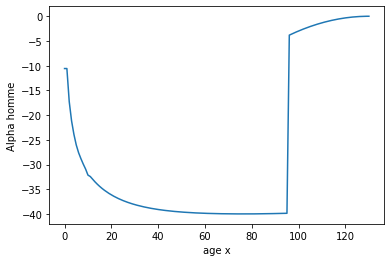

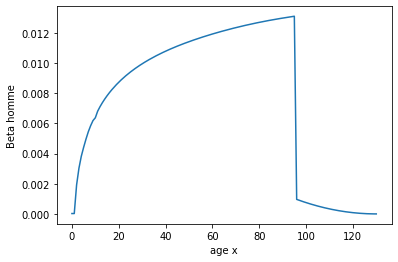

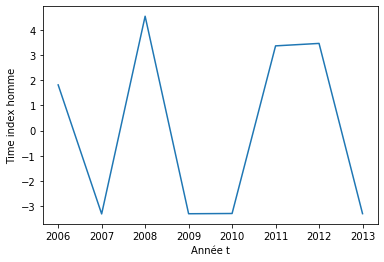

In [0]:
# Affichage des paramètres estimés

# a_male, b_male, k_male = Lee_carter(table_fermee_H)
# a_female, b_female, k_female = Lee_carter(table_fermee_F)
a_male, b_male, k_male = alpha, beta, k
#a_female, b_female, k_female = Lee_carter('F')
x = a_male['x']
t = k_male['t']
plt.plot(x, a_male['estimator'])
plt.xlabel('age x')
plt.ylabel('Alpha homme')
plt.show()
plt.plot(x, b_male['estimator'])
plt.xlabel('age x')
plt.ylabel('Beta homme')
plt.show()
plt.plot(t, k_male['estimator'])
plt.xlabel('Année t')
plt.ylabel('Time index homme')
plt.show()

#plt.plot(x, a_female['estimator'])
#plt.xlabel('age x')
#plt.ylabel('Alpha femme')
#plt.plot(x, b_female['estimator'])
#plt.xlabel('age x')
#plt.ylabel('Beta femme')
#plt.plot(t, k_female['estimator'])
#plt.xlabel('Année t')
#plt.ylabel('Time index femme')

## **4.2) Projection du facteur $k_t$**

Pour projeter l'indice $k_t$, on adopte la marche aléatoire suivante:
$$ k_t = k_{t-1} + d + \epsilon_t$$
où $\epsilon_t \sim N(0,1)$\
et où le drift $d$ est calculé en utilisant les valeurs de $k$ calculées précédemment:\
$ d = \frac{k_{t_n}-k_{t_1}}{t_n - t_1} $

# **5) Gestion actif-passif**



1.   
$$Cout = V(t=0) = E^{P*Q}[e^{-rT_x}(K-S_{T_x})1_{T_x <= T}] \
                = \int_{t = 0}^T C_t*P(T_x = t)dt$$
avec $C_t$ la prime d'un put européen de maturité t et de strike K.
Donc $$C_tt = Ke^{−rT} \phi_N(0,1)(d1) − S_0\phi_N(0,1)(d2)$$

2.   
Il suffit donc de calculer les prix des calls et puis utiliser les tables de mortalité pour les $P(T_x=t)$ selon l'age du client.
Pour le calcul sous integrale, on utilise la methode des differences finies.
On peut aussi utiliser monte carlo on diffusion de scénarios



In [0]:
def pgaussred(x):
    """fonction de répartition de la loi normale centrée réduite
       (= probabilité qu'une variable aléatoire distribuée selon
       cette loi soit inférieure à x)
       calcul par intégration numérique: 2000 tranches par écart-type
       résultat arrondi à 7 chiffres après la virgule
    """
    if x==0:
        return 0.5
    u=abs(x)
    n=int(u*2000)
    du=u/n
    k=1/sqrt(2*pi)
    u1=0
    f1=k
    p=0.5
    for i in range(0,n):
        u2=u1+du
        f2=k*exp(-0.5*u2*u2)
        p=p+(f1+f2)*du*0.5
        u1=u2
        f1=f2
    if x<0:
        p = 1.0-p
    return round(p, 7)

In [0]:
def prix_put(t,sigma,r,K,S0):
  d1 = (sigma*t^(1/2))^(-1)*log(K/S0)-(r*(t^(1/2)))/sigma+sigma*(t^(1/2))/2
  d2 = (sigma*t^(1/2))^(-1)*log(K/S0)-(r*(t^(1/2)))/sigma-sigma*(t^(1/2))/2
  F_m1 = pgaussred(-d1) #calcul de ΦN(0,1)(−d1) F_m2<-pnorm(-d2) #calcul de ΦN(0,1)(−d2)
  F_p1 = pgaussred(d1) #calcul de ΦN(0,1)(d1) F_p2<-pnorm(d2) #calcul de ΦN(0,1)(d2)
  P0 = K*exp(-r*t)*F_p1-S0*F_p2 #Calcul de P0
  return(P0)

In [0]:
def Prix_garantie(K,T,sigma,r,S0,mortalite):
  t = np.linspace(0,T,1000)
  dt = T/1000
  I = 0
  for t in dt:
    I = I + prix_put(t,sigma,r,K,S0)*mortalite[t]*dt
  return(I)